In [2]:
import sys
sys.path.append("../..")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
%matplotlib inline

In [3]:
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from new_train import train_nis
from new_train import train_nisp_rnis
from nis_net import NISNet
from nis_net import NISPNet
from nis_net import RNISNet
from datetime import datetime
from new_kuramoto import KuramotoModel
t0 = datetime.now()


use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0') if use_cuda else torch.device('cpu')
device

device(type='cuda', index=0)

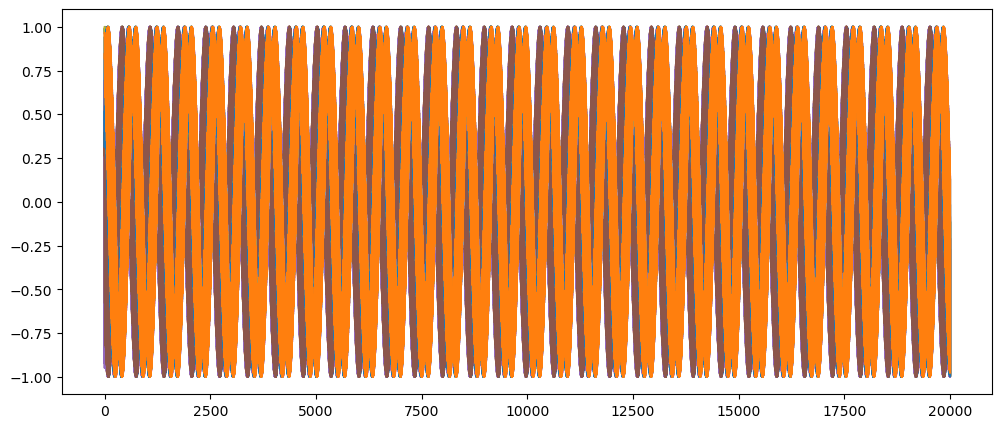

In [16]:
seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

kura_train = KuramotoModel(steps=20000, dt=0.01, sz=6, groups=1, coupling=5)
timeserie, timeserie_next, _, _ = kura_train.simulate_oneserie(sample_step=5)

plt.figure(figsize=(12,5))
for i in range(12):
    plt.plot(timeserie[:,i])
plt.show()

In [42]:
seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

kur_train = KuramotoModel(steps=20000, dt=0.01, sz=6, groups=2, coupling=5, sample_step=5, noise_p=0)
kur_test = KuramotoModel(steps=1000, dt=0.01, sz=6, groups=2, coupling=5, sample_step=5, noise_p=0)
train_data = [torch.FloatTensor(kur_train.input).to(device), torch.FloatTensor(kur_train.output).to(device)]
test_data = [torch.FloatTensor(kur_test.input).to(device), torch.FloatTensor(kur_test.output).to(device)]

# Train

In [43]:
# train params

T_total = 40001
clip = 500
sz = 12
scale = 12
hidden_units = 128
batch_size = 64
mae2_w = 3

# RNIS

In [44]:
seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
net_rnis = RNISNet(input_size=sz, latent_size=scale, output_size=sz, 
                        hidden_units=hidden_units, hidden_units_dyn=64,
                        is_normalized=True)
trainer = train_nisp_rnis(net=net_rnis, data=train_data, data_test=test_data, device=device)
trainer.training(T1=3000, T_all=T_total, mae2_w=mae2_w, batch_size=batch_size, clip=clip)
eis_rnis, term1s_rnis, term2s_rnis, losses_rnis, MAEs_mstep_rnis = trainer.return_log()
param_counts_rnis = trainer.param_counts

check point------step-> 17:42:42.170187; lasting 0:15:50.551386 seconds
Epoch: 0
Train loss: 0.0002
Test loss: 0.1481
dEI: 0.2576
term1: -4.9487
term2: 8.0400
------------------------------------------------------------------------------------------------------------------------
check point------step-> 17:43:13.392074; lasting 0:00:31.221887 seconds
Epoch: 500
Train loss: 0.0470
Test loss: 0.0182
dEI: 1.7137
term1: 11.3774
term2: 9.1867
------------------------------------------------------------------------------------------------------------------------
check point------step-> 17:43:44.721793; lasting 0:00:31.329719 seconds
Epoch: 1000
Train loss: 0.0082
Test loss: 0.0169
dEI: 1.8151
term1: 13.0297
term2: 8.7516
------------------------------------------------------------------------------------------------------------------------
check point------step-> 17:44:16.049074; lasting 0:00:31.327281 seconds
Epoch: 1500
Train loss: 0.0035
Test loss: 0.0151
dEI: 1.8824
term1: 13.9710
term2: 

# NIS

In [45]:
seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
net_nis = NISNet(input_size=sz, latent_size=scale, output_size=sz, 
                        hidden_units=hidden_units, is_normalized=True)
trainer = train_nis(net=net_nis, data=train_data, data_test=test_data, device=device)
trainer.training(T_all=T_total, batch_size=batch_size, clip=clip)
eis_nis, term1s_nis, term2s_nis, losses_nis, MAEs_mstep_nis = trainer.return_log()
param_counts_nis = trainer.param_counts

check point------step-> 18:32:02.493012; lasting 0:00:22.998108 seconds
Epoch: 0
Train loss: 0.0003
Test loss: 0.1210
dEI: 0.3801
term1: -3.7346
term2: 8.2964
------------------------------------------------------------------------------------------------------------------------
check point------step-> 18:32:14.943775; lasting 0:00:12.450763 seconds
Epoch: 500
Train loss: 0.0530
Test loss: 0.0195
dEI: 1.6713
term1: 11.5693
term2: 8.4866
------------------------------------------------------------------------------------------------------------------------
check point------step-> 18:32:26.109547; lasting 0:00:11.165772 seconds
Epoch: 1000
Train loss: 0.0109
Test loss: 0.0165
dEI: 1.8218
term1: 13.4282
term2: 8.4335
------------------------------------------------------------------------------------------------------------------------
check point------step-> 18:32:38.542126; lasting 0:00:12.432579 seconds
Epoch: 1500
Train loss: 0.0062
Test loss: 0.0142
dEI: 1.9606
term1: 15.1072
term2: 

# NIS+

In [ ]:
seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
net_nisp = NISPNet(input_size=sz, latent_size=scale, output_size=sz, 
                        hidden_units=hidden_units, hidden_units_dyn=hidden_units,
                        is_normalized=True)
trainer = train_nisp_rnis(net=net_nisp, data=train_data, data_test=test_data, device=device)
trainer.training(T1=3000, T_all=T_total, mae2_w=mae2_w, batch_size=batch_size, clip=clip)
eis_nisp, term1s_nisp, term2s_nisp, losses_nisp, MAEs_mstep_nisp = trainer.return_log()
param_counts_nisp = trainer.param_counts

check point------step-> 18:47:56.491727; lasting 0:00:03.902288 seconds
Epoch: 0
Train loss: 0.0003
Test loss: 0.1299
dEI: 0.3060
term1: -4.6484
term2: 8.3203
------------------------------------------------------------------------------------------------------------------------
check point------step-> 18:48:08.653061; lasting 0:00:12.161334 seconds
Epoch: 500
Train loss: 0.0409
Test loss: 0.0205
dEI: 1.6448
term1: 11.1817
term2: 8.5558
------------------------------------------------------------------------------------------------------------------------
check point------step-> 18:48:22.901917; lasting 0:00:14.248856 seconds
Epoch: 1000
Train loss: 0.0078
Test loss: 0.0188
dEI: 1.7414
term1: 12.4068
term2: 8.4903
------------------------------------------------------------------------------------------------------------------------
check point------step-> 18:48:38.179827; lasting 0:00:15.277910 seconds
Epoch: 1500
Train loss: 0.0044
Test loss: 0.0184
dEI: 1.7714
term1: 12.7839
term2: 

# Result

In [ ]:
print(param_counts_nis, param_counts_nisp, param_counts_rnis)

In [40]:
losses_nis[-1], losses_nisp[-1], losses_rnis[-1]

(0.20218898355960846, 0.2109643390344801, 0.206871408285503)

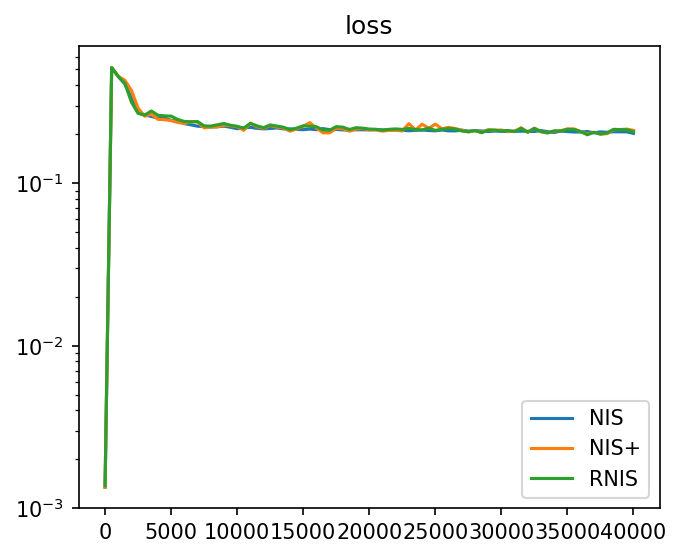

In [41]:
plt.figure(figsize=(5,4),dpi=150)
timeseries = np.arange(len(eis_nis)) * clip
plt.plot(timeseries, losses_nis, label='NIS')
timeseries = np.arange(len(losses_nisp)) * clip
plt.plot(timeseries, losses_nisp, label='NIS+')
timeseries = np.arange(len(losses_rnis)) * clip
plt.plot(timeseries, losses_rnis, label='RNIS')
plt.title(r'loss')
plt.legend()
plt.yscale('log')
plt.show()

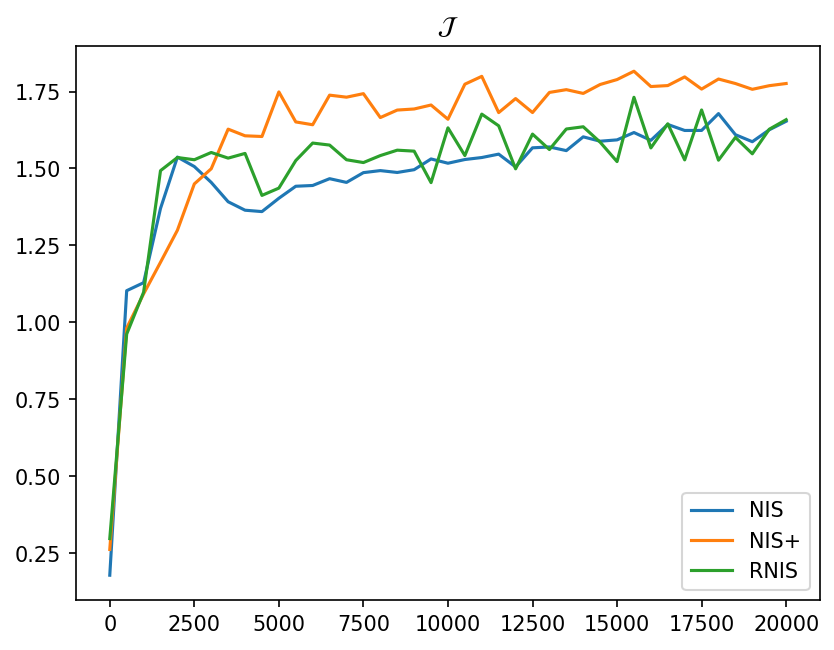

In [32]:
plt.figure(dpi=150)
timeseries = np.arange(len(eis_nis)) * clip
plt.plot(timeseries, eis_nis, label='NIS')
timeseries = np.arange(len(eis_nisp)) * clip
plt.plot(timeseries, eis_nisp, label='NIS+')
timeseries = np.arange(len(eis_rnis)) * clip
plt.plot(timeseries, eis_rnis, label='RNIS')
plt.title(r'$\mathcal{J}$')
plt.legend()
plt.show()

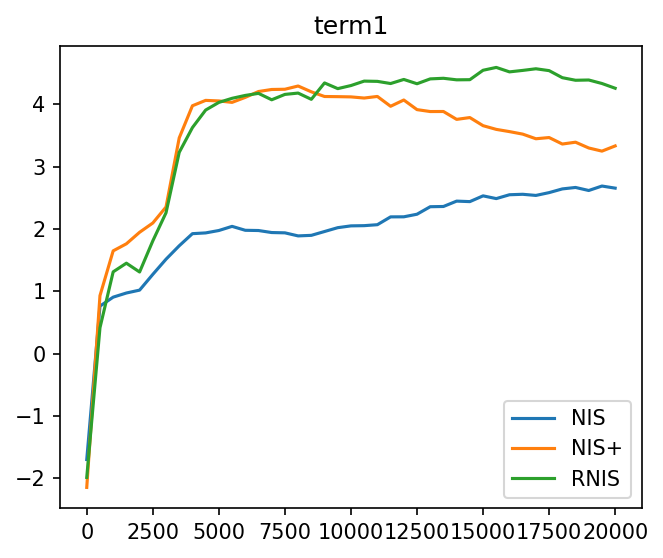

In [14]:
plt.figure(figsize=(5,4),dpi=150)
timeseries = np.arange(len(eis_nis)) * clip
plt.plot(timeseries, term1s_nis, label='NIS')
timeseries = np.arange(len(term1s_nisp)) * clip
plt.plot(timeseries, term1s_nisp, label='NIS+')
timeseries = np.arange(len(term1s_rnis)) * clip
plt.plot(timeseries, term1s_rnis, label='RNIS')
plt.title(r'term1')
plt.legend()
# plt.yscale('log')
plt.show()

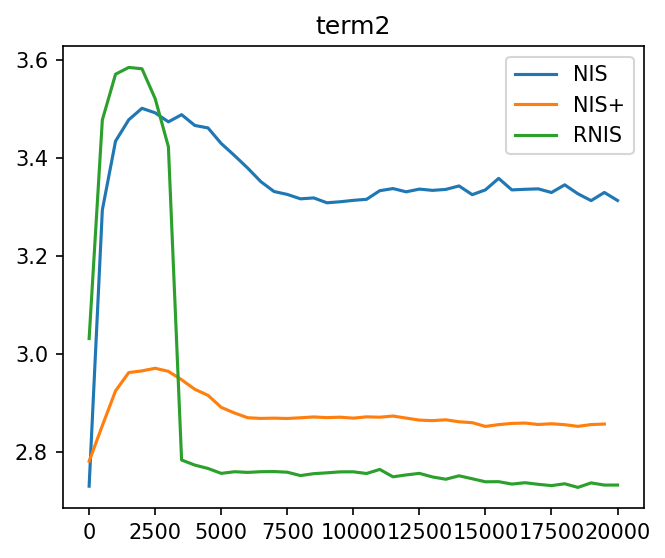

In [29]:
plt.figure(figsize=(5,4),dpi=150)
timeseries = np.arange(len(eis_nis)) * clip
plt.plot(timeseries, term2s_nis, label='NIS')
timeseries = np.arange(len(term1s_nisp)) * clip
plt.plot(timeseries, term2s_nisp, label='NIS+')
timeseries = np.arange(len(term2s_rnis)) * clip
plt.plot(timeseries, term2s_rnis, label='RNIS')
plt.title(r'term2')
plt.legend()
# plt.yscale('log')
plt.show()

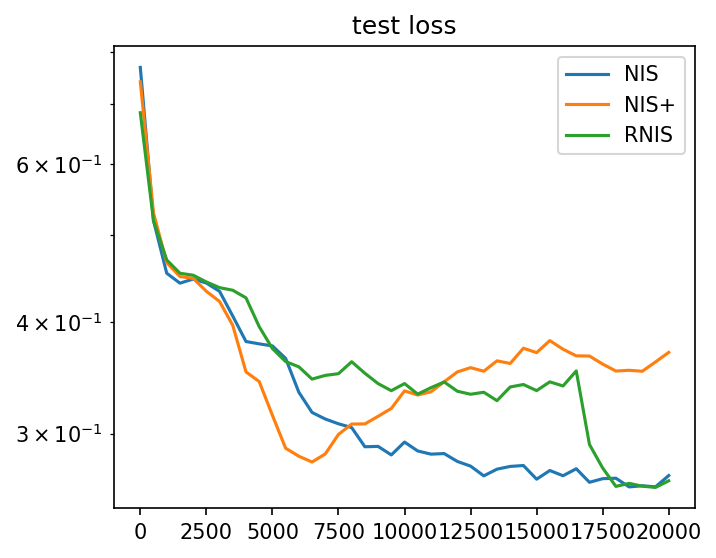

In [25]:
plt.figure(figsize=(5,4),dpi=150)
timeseries = np.arange(len(eis_nis)) * clip
plt.plot(timeseries, MAEs_mstep_nis, label='NIS')
timeseries = np.arange(len(MAEs_mstep_nisp)) * clip
plt.plot(timeseries, MAEs_mstep_nisp, label='NIS+')
timeseries = np.arange(len(MAEs_mstep_rnis)) * clip
plt.plot(timeseries, MAEs_mstep_rnis, label='RNIS')
plt.title(r'test loss')
plt.legend()
plt.yscale('log')
plt.show()